In [1]:
import pandas as pd
from fbprophet import Prophet
from datetime import datetime
df = pd.read_csv('Applications_date.csv', parse_dates=True).sort_values(by='year_month_day')
df.rename(columns={'year_month_day':'ds', 'num_customers':'y'}, inplace=True)
df.head()
# df = df[df['ds']>'2016-01']#'=datetime(year=2016, month=1, day=1)]
frame = {'ds':[], 'y':[]}

In [2]:
temp = None
for idx, row in df.iterrows():
    if temp == None:
        temp = row['y']
        #frame['ds'].append(0)
        #frame['y'].append(0)
        continue
    frame['ds'].append(row['ds'])
    frame['y'].append(row['y']-temp)
    temp = row['y']
df2 = pd.DataFrame(frame)
df2 = df2[abs(df2['y'])<20]

In [8]:
m1 = Prophet(interval_width=0.70)
m2 = Prophet(interval_width=0.70)
m1.fit(df)
m2.fit(df2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
future1 = m1.make_future_dataframe(periods=365)
future2 = m2.make_future_dataframe(periods=365)

In [20]:
forecast1 = m1.predict(future1)
forecast2 = m2.predict(future2)

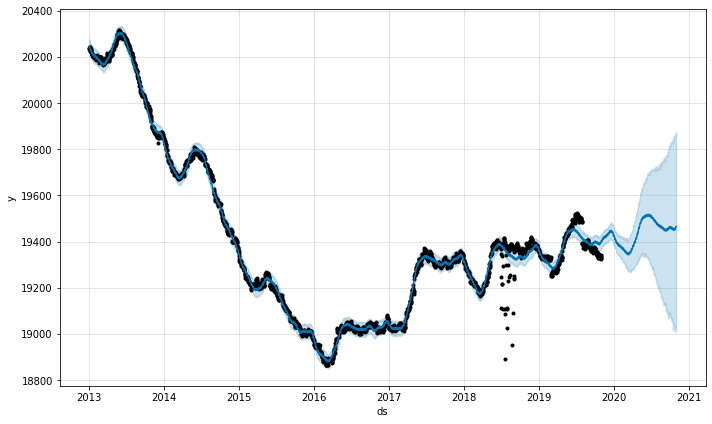

In [21]:
fig1 = m1.plot(forecast1)

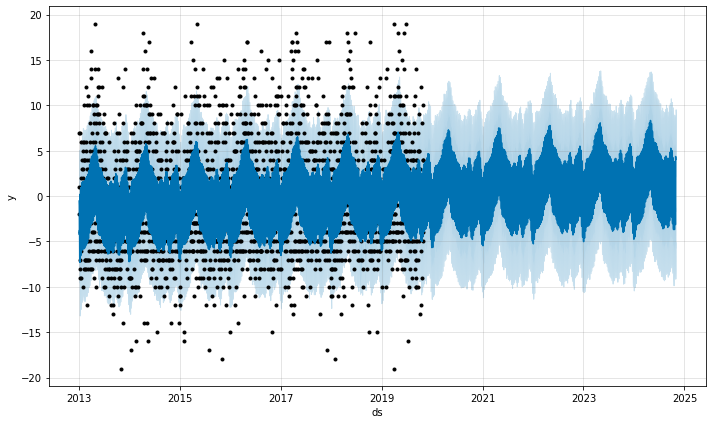

In [16]:
fig2 = m2.plot(forecast2)

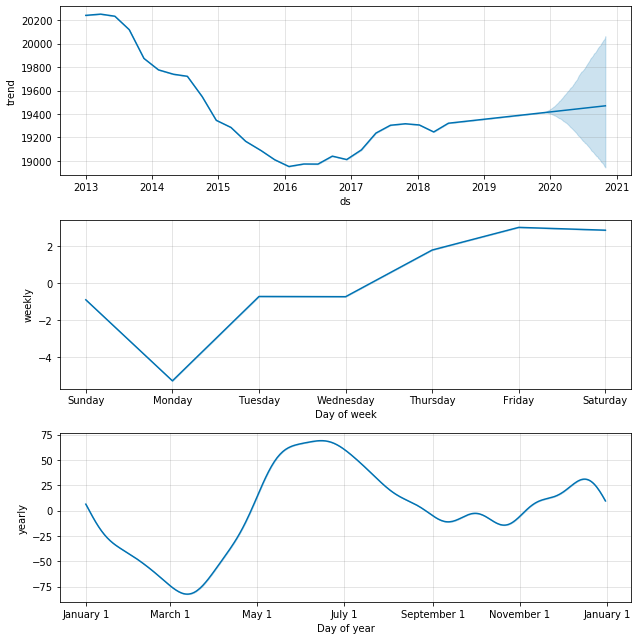

In [8]:
fig3 = m1.plot_components(forecast1)

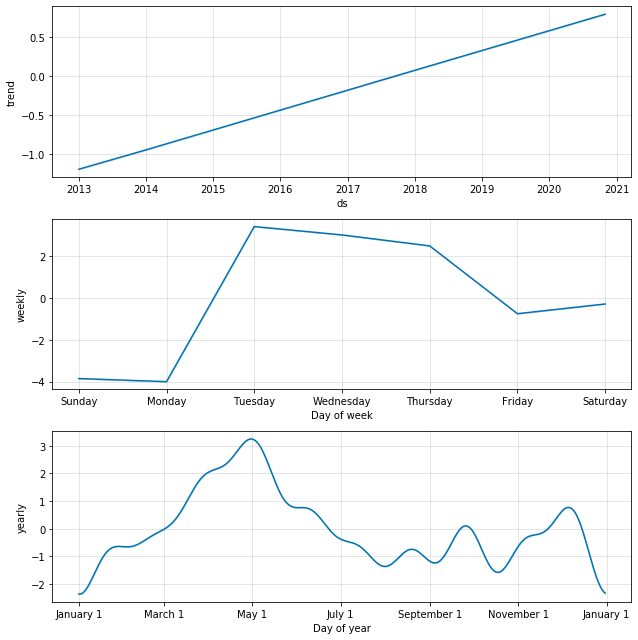

In [9]:
fig4 = m2.plot_components(forecast2)

# Trend Optimization

In [34]:
import numpy as np
from pandas import read_csv
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor
from InventoryOptim.inventory import InventoryOptim
from NpyProximation import HilbertRegressor
from numpy import sin, cos, exp

In [35]:
import warnings
warnings.filterwarnings("ignore", category=Warning)

try:
    df = read_csv('CFS.csv', parse_dates=['ds'], infer_datetime_format=True)
except FileNotFoundError:
    df = read_csv('./examples/CFS.csv', parse_dates=['ds'], infer_datetime_format=True)
pairs= [('FC', 'FCc'), ('GH', 'GHc'), ('EF', 'EFc'), ('OP', 'OPc'), ('SH', 'SHc')]

In [36]:
# define regressors
param_grid_sgd = {"alpha": np.logspace(-4, 0, 5),
                  "penalty": ['none', 'l1', 'l2', 'elasticnet'],
                  "tol": np.logspace(-4, 0, 5)}
sgd_regressor = RandomizedSearchCV(SGDRegressor(), param_distributions=param_grid_sgd, n_iter=25, cv=2)

deg = 5
skip = 1
l = 0.1
base = [lambda x: 1., lambda x: x[0]] + \
    [lambda x, l=l, _=_: sin(_*x[0]/l) for _ in range(1, deg+1, skip)] + \
    [lambda x, l=l, _=_: cos(_*x[0]/l) for _ in range(1, deg+1, skip)]
regressor = HilbertRegressor(base=base)
# initialize
s_date = datetime(year=2018, month=1, day=1)

<Figure size 2160x1440 with 0 Axes>

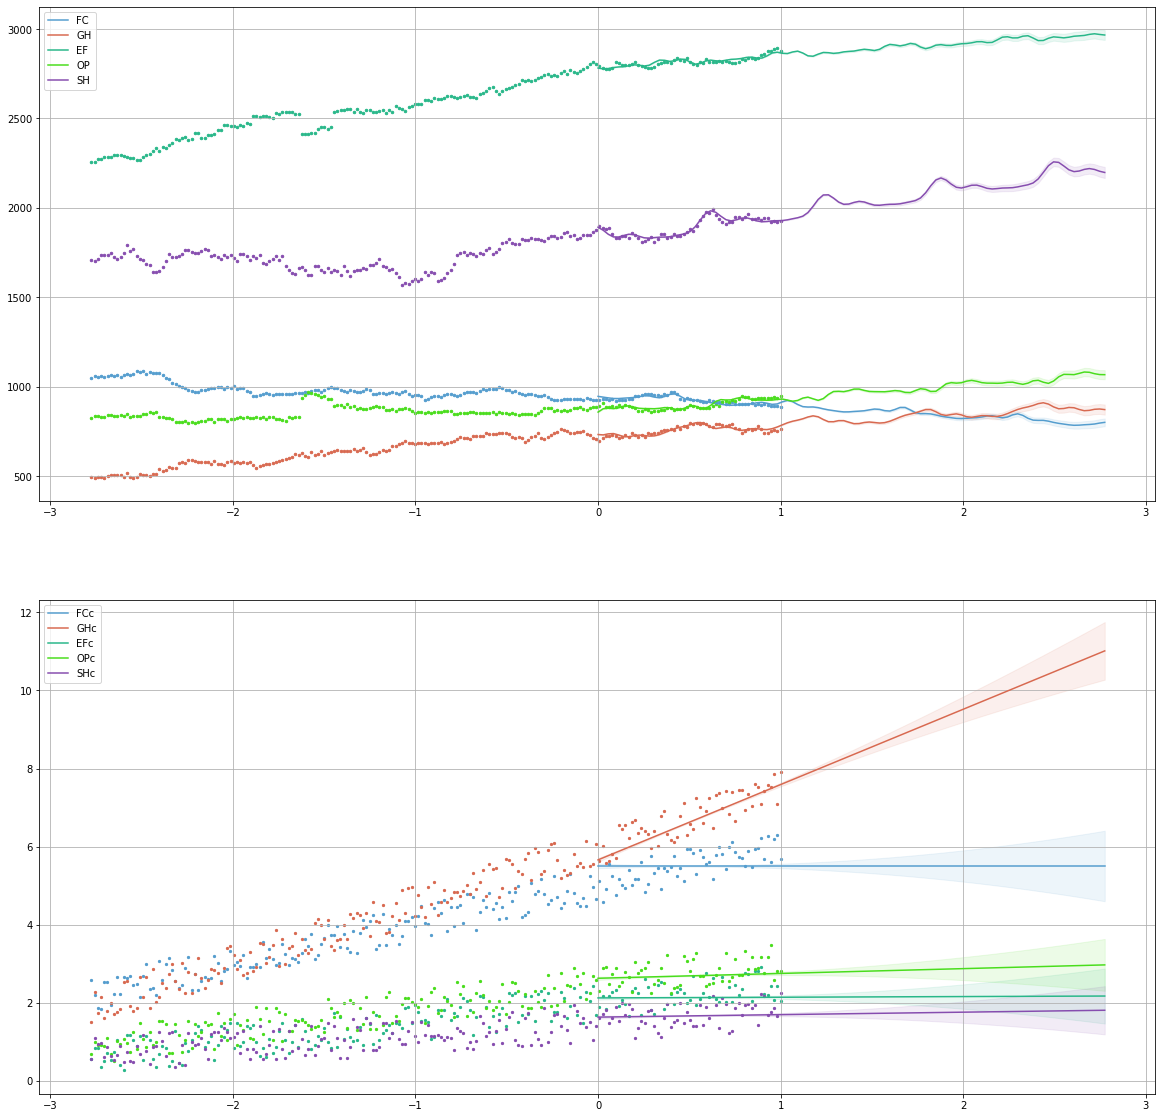

In [37]:
instance = InventoryOptim(df, date_fld='ds', units_costs=pairs, start_date=s_date,
                          num_intrvl=(0., 1.), projection_date=datetime(year=2021, month=1, day=1),
                          c_limit=.95)
instance.set_unit_count_regressor(regressor)
instance.set_cost_regressor(sgd_regressor)
instance.fit_regressors()
instance.plot_init_system().savefig('init.png', dpi=200)
instance.budget = lambda t: 30000-22000*np.exp(-t-1.)

In [38]:
# constraints
instance.constraint('GH', 650, datetime(year=2020, month=6, day=1))
instance.constraint('FC', 700, datetime(year=2019, month=12, day=1))
instance.constraint('EF', 2900, datetime(year=2020, month=6, day=1))
instance.constraint('FCc', 6., datetime(year=2020, month=1, day=1))
instance.constraint('GHc', 8., datetime(year=2021, month=1, day=1))
instance.constraint('EFc', 2.5, datetime(year=2020, month=1, day=1))
instance.constraint('OPc', 3.5, datetime(year=2020, month=1, day=1))

In [39]:
# run
instance.adjust_system(tbo='b')
fig = instance.plot_analysis()
fig[1].savefig('results.png', dpi=200)

KeyboardInterrupt: 